In [1]:
# 如果没有安装pandas，则反注释下面一行
# !pip install pandas

%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.max_columns = None
pd.options.display.max_rows = None

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

path = "house-prices-advanced-regression-techniques/"
train_data = pd.read_csv(path+"train.csv")
test_data = pd.read_csv(path+"test.csv")

1.9.1


In [2]:
train_data.shape
test_data.shape

(1460, 81)

(1459, 80)

In [3]:
train_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [4]:
def data_pre_process(train_data,test_data,id_remove=False):
    
    df = pd.concat((train_data,test_data))
    
    if id_remove:
        #去掉ID列
        df = df.iloc[:,1:]
    
    num_features = train_data.dtypes[train_data.dtypes!='object'].index  
    train_df_mean = dict(train_data[num_features].mean())
    train_df_std = dict(train_data[num_features].std())
    
    # dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
    df = pd.get_dummies(df,dummy_na = True)
    
    # 标准化数值列
    # 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
    for f in num_features:
        df.loc[:,f] = (df.loc[:,f]-train_df_mean[f])/train_df_std[f]
    
    df.loc[:,num_features] = df.loc[:,num_features].fillna(0)
    
    train_df = df.iloc[:train_data.shape[0],:]
    test_df = df.iloc[train_data.shape[0]:,:]
    
    return train_df,test_df,train_df_mean,train_df_std

def label_pre_processing(label_df):
    label_mean = label_df.mean()
    label_std = label_df.std()
    return (label_df-label_mean)/label_std,label_mean,label_std


In [5]:
train_df,test_df,mean,std = data_pre_process(train_data.iloc[:,1:-1],test_data.iloc[:,1:])
#label_df,label_mean,label_std = label_pre_processing(train_data.iloc[:,-1])
label_df = train_data.iloc[:,-1]

In [6]:
train_features = torch.tensor(train_df.values,dtype = torch.float)
test_features = torch.tensor(test_df.values,dtype = torch.float)
train_labels = torch.tensor(label_df.values, dtype=torch.float).view(-1, 1)

In [7]:
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [8]:
test_features

tensor([[-0.8723,  0.4097,  0.1107,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8723,  0.4509,  0.3757,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0733,  0.1627,  0.3319,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-0.8723,  3.7040,  0.9501,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6644, -0.3315, -0.0076,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0733,  0.1627, -0.0891,  ...,  1.0000,  0.0000,  0.0000]])

In [12]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net
'''
def get_net(num_inputs, num_hiddens = 64,num_outputs=1):
    net = nn.Sequential(
        nn.Linear(num_inputs, num_hiddens),
        nn.Tanh(),
        nn.Linear(num_hiddens, num_outputs)
        )

    for params in net.parameters():
        nn.init.normal_(params, mean=0, std=0.01)
    return net
'''

def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()


def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    #net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        #train_ls.append(torch.sqrt(loss(net(train_features),train_labels)))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            #test_ls.append(torch.sqrt(loss(net(test_features),test_labels)))
    return train_ls, test_ls


def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        # 在变量前加单星号表示将元组(列表、集合)拆分为单个元素。
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

'\ndef get_net(num_inputs, num_hiddens = 64,num_outputs=1):\n    net = nn.Sequential(\n        nn.Linear(num_inputs, num_hiddens),\n        nn.Tanh(),\n        nn.Linear(num_hiddens, num_outputs)\n        )\n\n    for params in net.parameters():\n        nn.init.normal_(params, mean=0, std=0.01)\n    return net\n'

fold 0, train rmse 0.169435, valid rmse 0.158932
fold 1, train rmse 0.162328, valid rmse 0.182957
fold 2, train rmse 0.162801, valid rmse 0.167433
fold 3, train rmse 0.167408, valid rmse 0.153958
fold 4, train rmse 0.161319, valid rmse 0.183420
5-fold validation: avg train rmse 0.164658, avg valid rmse 0.169340


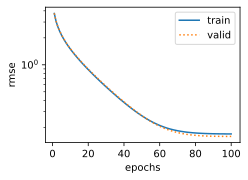

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

train rmse 0.162084


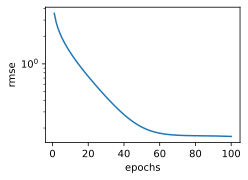

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)